In [5]:
import datetime
import gc
import random
import time

import numpy, numpy.random
import pandas
import scipy
from scipy import sparse
import matplotlib.pyplot as plt
import IPython.display as disp

class Progress:
    """Wrapper for IPython.display.ProgressBar with improved performance"""

    def __init__(self, total):
        self.bar = disp.ProgressBar(total)
        self.total = total
        self.progress = 0
        self.last = 0
        self.start = time.monotonic_ns()

    def inc(self, delta=1):
        self.progress += delta
        if time.monotonic_ns() - self.last > 1e8:
            self.bar.progress = self.progress
            self.bar.update()
            self.last = time.monotonic_ns()

    def __enter__(self):
        return self
    def __exit__(self, exc_type, exc_value, tb):
        self.bar.progress = self.progress
        self.bar.update()
        print(f"Completed {self.progress}/{self.total} in {(time.monotonic_ns() - self.start) / 1000000}ms")
        return False

class Timer:
    def __init__(self, name):
        self.name = name
    
    def __enter__(self):
        self.start = time.monotonic_ns()
        print(f"Task: {self.name}")

    def __exit__(self, exc_type, exc_value, tb):
        end = time.monotonic_ns()
        time_ns = end - self.start
        print(f"Took {time_ns / 1000000}ms")
        return False

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!test -d dataset || unzip /content/drive/Shareddrives/'STAT4609 Netflix'/dataset.zip -d dataset

Archive:  /content/drive/Shareddrives/STAT4609 Netflix/dataset.zip
  inflating: dataset/README          
  inflating: dataset/combined_data_1.txt  
  inflating: dataset/combined_data_2.txt  
  inflating: dataset/combined_data_3.txt  
  inflating: dataset/combined_data_4.txt  
  inflating: dataset/movie_titles.csv  
  inflating: dataset/probe.txt       
  inflating: dataset/qualifying.txt  


In [8]:
!cp /content/drive/Shareddrives/'STAT4609 Netflix'/preprocess-dataset /usr/local/bin
!chmod +x /usr/local/bin/preprocess-dataset
!test -f dataset/output.npy || (cd dataset && preprocess-dataset)

Read 1000000 lines of probe
Read 1000000 lines
Read 2000000 lines
Read 3000000 lines
Read 4000000 lines
Read 5000000 lines
Read 6000000 lines
Read 7000000 lines
Read 8000000 lines
Read 9000000 lines
Read 10000000 lines
Read 11000000 lines
Read 12000000 lines
Read 13000000 lines
Read 14000000 lines
Read 15000000 lines
Read 16000000 lines
Read 17000000 lines
Read 18000000 lines
Read 19000000 lines
Read 20000000 lines
Read 21000000 lines
Read 22000000 lines
Read 23000000 lines
Read 24000000 lines
Empty line!
Read 25000000 lines
Read 26000000 lines
Read 27000000 lines
Read 28000000 lines
Read 29000000 lines
Read 30000000 lines
Read 31000000 lines
Read 32000000 lines
Read 33000000 lines
tcmalloc: large alloc 1879048192 bytes == 0x55cfec484000 @  0x7f0e4b1b62a4 0x55cf7a2a0120 0x55cf7a2a0265 0x55cf7a29ef2a 0x55cf7a29d5de 0x55cf7a29f956 0x55cf7a29f96c 0x55cf7a2ba30a 0x55cf7a29f855 0x7f0e4a777bf7 0x55cf7a29be3e
Read 34000000 lines
Read 35000000 lines
Read 36000000 lines
Read 37000000 lines
Read

In [9]:
COL_USER = 0
COL_MOVIE = 1
COL_RATING = 2
COL_YEAR = 3
COL_DOY = 4
COL_DOW = 5
COL_PROBED = 6

with Timer("Loading data..."):
    data = numpy.load("dataset/output.npy")
    data_size = data.shape[0]

with Timer("Counting users and movies"):
    user_count = numpy.max(data[:, COL_USER]) + 1
    movie_count = numpy.max(data[:, COL_MOVIE]) + 1

with Timer("Copying train/test split"):
    train = data[data[:, 6] == 0, :3].copy()
    evaluation = data[data[:, 6] == 1, :3].copy()

# Free the memory used to hold the whole dataset
del data
gc.collect()

print(f"Train/test size: {train.shape[0]}/{evaluation.shape[0]}")

evaluation_results = {}

Task: Loading data...
Took 3274.540201ms
Task: Counting users and movies
Took 481.818865ms
Task: Copying train/test split
Took 4687.778191ms
Train/test size: 99072112/1408395


In [15]:
class SliceLoader:
    def __init__(self, matrix, batch_size):
        self.matrix = matrix
        self.batch_size = batch_size
        self.ptr = 0

    def __iter__(self):
        return self

    def __next__(self):
        end = min(self.ptr + self.batch_size, self.matrix.shape[0])
        size = end - self.ptr
        if size == 0:
            raise StopIteration
        ret = self.matrix[self.ptr:end, :]
        self.ptr = end
        return ret

In [53]:
class SvdRecommend:
    def __init__(self, alpha, reg, rank, batch_size, epochs):
        self.alpha = alpha
        self.reg = reg
        self.rank = rank
        self.batch_size = batch_size
        self.epochs = epochs

    def get_params(self):
        return (self.alpha, self.reg, self.rank, self.batch_size, self.epochs)

    def fit(self, ratings):
        raise Exception("Uninitialized function")

    def predict_rating(self, user_id, movie_id):
        raise Exception("Uninitialized function")

    def evaluate(self, max_user=None, max_movie=None):
        gc.collect()

        train_sample = train
        test_sample = evaluation

        if max_user is not None:
            train_sample = train_sample[train_sample[:, COL_USER] <= max_user]
            test_sample = test_sample[test_sample[:, COL_USER] <= max_user]

        if max_movie is not None:
            train_sample = train_sample[train_sample[:, COL_MOVIE] <= max_movie]
            test_sample = test_sample[test_sample[:, COL_MOVIE] <= max_movie]
        
        self.fit(train_sample)

        print(f"Evaluating {test_sample.shape[0]} probe rows")

        pred = self.predict(test_sample[:, [COL_USER, COL_MOVIE]])
        target = test_sample[:, COL_RATING]
        nan_count = numpy.isnan(pred).sum()
        if nan_count > 0:
            print(f"{nan_count} predicted rows are inconclusive")

        rmse = numpy.sqrt(numpy.nanmean((pred - target) ** 2))
        evaluation_results[self.get_params()] = rmse

        print(f"Hyperparameters: {self.get_params()}")
        print(f"Probe RMSE: {rmse}")
        plt.plot(numpy.arange(self.epochs) + 1, self.rmse_history)
        plt.xlabel("Epochs")
        plt.ylabel("RMSE")
        plt.show()

In [73]:
def _fit(self, ratings):
    gc.collect()

    # express as a sparse matrix such that coo[user, movie] = rating
    with Timer("Counting users and movies"):
        user_count = ratings[:, COL_USER].max() + 1
        movie_count = ratings[:, COL_MOVIE].max() + 1

    with Timer("Packing data in COO format"):
        coo = sparse.coo_matrix((ratings[:, COL_RATING], (ratings[:, COL_USER], ratings[:, COL_MOVIE])))
    with Timer("Computing global mean"):
        mu = ratings[:, COL_RATING].mean()

    with Timer("Counting ratings per user"):
        per_user_ratings = numpy.asarray((coo != 0.0).sum(axis=1)).flatten()
    with Timer("Counting ratings per movie"):
        per_movie_ratings = numpy.asarray((coo != 0.0).sum(axis=0)).flatten()

    with Timer("Computing user bias"):
        bias_users = numpy.asarray(coo.sum(axis=1)).flatten() / per_user_ratings - mu
    with Timer("Computing movie bias"):
        bias_movies = numpy.asarray(coo.sum(axis=0)).flatten() / per_movie_ratings - mu
    
    with Timer("Initializing parameters"):
        var = numpy.std(ratings[:, COL_RATING]) / 100

        # bias_users = numpy.clip(numpy.random.normal(scale=var, size=user_count), -1, 1)
        # bias_movies = numpy.clip(numpy.random.normal(scale=var, size=movie_count), -1, 1)

        latent_users = numpy.clip(numpy.random.normal(scale=var, size=(user_count, self.rank)), -1, 1)
        latent_movies = numpy.clip(numpy.random.normal(scale=var, size=(movie_count, self.rank)), -1, 1)

    with Timer("Performing gradient descent"):
        rmse_history = numpy.empty(self.epochs)

        with Progress(self.epochs * ratings.shape[0]) as progress:
            um_prod_buf = numpy.empty((self.batch_size, self.rank))
            e_prod_buf = numpy.empty((self.batch_size, self.rank))
            r_prod_buf = numpy.empty((self.batch_size, self.rank))

            try:
                for epoch in range(self.epochs):
                    mse_sum = 0.0
    
                    loader = SliceLoader(ratings, self.batch_size)
                    for batch in loader:
                        b = batch.shape[0]
    
                        users = batch[:, COL_USER]
                        movies = batch[:, COL_MOVIE]
                        targets = batch[:, COL_RATING].astype(float)
    
                        um_prod = um_prod_buf[:b, :]
                        numpy.multiply(latent_users[users, :], latent_movies[movies, :], out=um_prod)
    
                        pred = mu.copy()
                        pred += bias_users[users]
                        pred += bias_movies[movies]
                        pred += um_prod.sum(axis=1)
    
                        err = targets - pred
                        mse = numpy.dot(err, err)
                        mse_sum += mse
                        # print(numpy.sqrt(mse / b))
    
                        # Caution: in the lines below,
                        # use numpy.add.at(a, k, b) instead of a[k] += b
                        # because `users` may contain duplicate entries
    
                        # delta = self.alpha * (err - self.reg * bias_users[users])
                        # delta /= numpy.sqrt(per_user_ratings[users])
                        """
                        _, axes = plt.subplots(1, 5, figsize=(30, 5))
                        axes[0].hist(bias_users)
                        axes[0].set_title("bias_users before")
                        axes[1].hist(bias_users[users])
                        axes[1].set_title("bias_users[users] before")
                        axes[2].hist(delta)
                        axes[2].set_title("bias_users delta")
                        """
                        # numpy.add.at(bias_users, users, delta)
                        """
                        axes[3].hist(bias_users)
                        axes[3].set_title("bias_users after")
                        axes[4].hist(bias_users[users])
                        axes[4].set_title("bias_users[users] after")
                        plt.show()
                        """
    
                        # delta = self.alpha * (err - self.reg * bias_movies[movies])
                        # delta /= numpy.sqrt(per_movie_ratings[movies])
                        # numpy.add.at(bias_movies, movies, delta)
    
                        # Unvectorized version:
                        # latent_users[user, :] += self.learning_rate * (err * latent_movies[movie, :] - self.regularization * latent_users[user, :])
                        e_prod = e_prod_buf[:b, :]
                        numpy.multiply(latent_movies[movies, :], err.reshape((-1, 1)), out=e_prod)
                        r_prod = r_prod_buf[:b, :]
                        r_prod[:, :] = latent_users[users, :]
                        r_prod *= self.reg
                        e_prod /= numpy.sqrt(per_user_ratings[users].reshape(-1, 1))
                        r_prod /= per_user_ratings[users].reshape(-1, 1)
                        e_prod -= r_prod
                        e_prod *= self.alpha
                        numpy.add.at(latent_users, users, e_prod) 
                        numpy.clip(latent_users, -5, 5, out=latent_users)
    
                        # Unvectorized version:
                        # latent_movies[movie, :] += self.learning_rate * (err * latent_users[user, :] - self.regularization * latent_movies[movie, :])
                        numpy.multiply(latent_users[users, :], err.reshape((-1, 1)), out=e_prod)
                        r_prod[:, :] = latent_movies[movies, :]
                        r_prod *= self.reg
                        e_prod /= numpy.sqrt(per_movie_ratings[movies].reshape(-1, 1))
                        r_prod /= per_movie_ratings[movies].reshape(-1, 1)
                        e_prod -= r_prod
                        e_prod *= self.alpha
                        numpy.add.at(latent_movies, movies, e_prod)
                        numpy.clip(latent_movies, -5, 5, out=latent_movies)
    
                        progress.inc(delta=b)
    
                        # print(bias_users)
                        # print(bias_movies)
                        # print(latent_users)
                        # print(latent_movies)
    
                    rmse_history[epoch] = numpy.sqrt(mse_sum / ratings.shape[0])
                    print(f"Epoch {epoch}: {rmse_history[epoch]}")
    
                    """
                    _, axes = plt.subplots(1, 4, figsize=(20, 5))
                    axes[0].hist(bias_users)
                    axes[0].set_title("bias_users")
                    axes[1].hist(bias_movies)
                    axes[1].set_title("bias_movies")
                    axes[2].hist(latent_users.flatten())
                    axes[2].set_title("latent_users")
                    axes[3].hist(latent_movies.flatten())
                    axes[3].set_title("latent_movies")
                    plt.show()
                    """
            except KeyboardInterrupt:
                pass

    self.mu = mu
    self.bias_users = bias_users
    self.bias_movies = bias_movies
    self.latent_users = latent_users
    self.latent_movies = latent_movies

    self.rmse_history = rmse_history

    return self


SvdRecommend.fit = _fit

In [67]:
def _predict(self, um):
    """um is an n*2 matrix.
    The first column is the user ID.
    The second column is the movie ID.
    Returns a size n vector of predicted ratings."""

    users = um[:, COL_USER]
    movies = um[:, COL_MOVIE]

    ret = self.mu.copy()
    ret += self.bias_users[users]
    ret += self.bias_movies[movies]
    ret += numpy.sum(self.latent_users[users, :] * self.latent_movies[movies, :], axis=1)

    return ret

SvdRecommend.predict = _predict

Task: Counting users and movies
Took 273.631099ms
Task: Packing data in COO format
Took 798.892142ms
Task: Computing global mean
Took 168.567799ms
Task: Counting ratings per user
Took 14817.296819ms
Task: Counting ratings per movie
Took 14442.07016ms
Task: Computing user bias
Took 1202.819485ms
Task: Computing movie bias
Took 1711.884201ms
Task: Initializing parameters
Took 876.170257ms
Task: Performing gradient descent


[============================================================] 1981442240/1981442240

Epoch 0: 0.9244260981478505
Epoch 1: 0.9244222509525296
Epoch 2: 0.9244176035884472
Epoch 3: 0.9244110067959971
Epoch 4: 0.9243997797660728
Epoch 5: 0.9243759971771623
Epoch 6: 0.9243124483306707
Epoch 7: 0.9241077025305277
Epoch 8: 0.9233750706576282
Epoch 9: 0.9207522378796467
Epoch 10: 0.9130757075937047
Epoch 11: 0.9011763882162023
Epoch 12: 0.8942749366360823
Epoch 13: 0.8897828971368414
Epoch 14: 0.8843184225341888
Epoch 15: 0.8773809562675267
Epoch 16: 0.8698065778716306
Epoch 17: 0.8622861125461294
Epoch 18: 0.855292441300142
Epoch 19: 0.8492551079630799
Completed 1981442240/1981442240 in 5020962.681109ms
Took 5020963.693498ms
Evaluating 1408395 probe rows
Hyperparameters: (0.05, 0.0, 10, 1048576, 20)
Probe RMSE: 0.9572792349478484


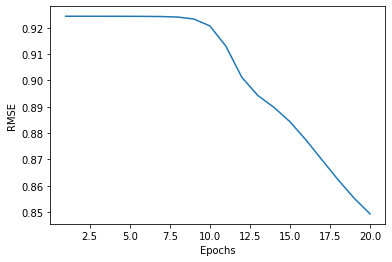

In [68]:
numpy.random.seed(4609)
model = SvdRecommend(0.05, 0.0, 10, 1048576, 20)
model.evaluate()

Task: Counting users and movies
Took 259.896432ms
Task: Packing data in COO format
Took 761.334923ms
Task: Computing global mean
Took 171.595082ms
Task: Counting ratings per user
Took 19981.724548ms
Task: Counting ratings per movie
Took 14827.719012ms
Task: Computing user bias
Took 1172.250306ms
Task: Computing movie bias
Took 1683.939606ms
Task: Initializing parameters
Took 884.709544ms
Task: Performing gradient descent


[============================================================] 1981442240/1981442240

Epoch 0: 0.9244260981170793
Epoch 1: 0.9244222545745737
Epoch 2: 0.9244176197017419
Epoch 3: 0.9244110491710368
Epoch 4: 0.9243998757812218
Epoch 5: 0.9243762161512199
Epoch 6: 0.9243130105872612
Epoch 7: 0.9241094306060045
Epoch 8: 0.9233812226548432
Epoch 9: 0.9207743625731215
Epoch 10: 0.9131345558663901
Epoch 11: 0.9012410153462539
Epoch 12: 0.8943158922545479
Epoch 13: 0.8898384102652717
Epoch 14: 0.8844035899034468
Epoch 15: 0.8774937134373425
Epoch 16: 0.8699345913437568
Epoch 17: 0.8624209277208523
Epoch 18: 0.855423075140603
Epoch 19: 0.8493734009153564
Completed 1981442240/1981442240 in 5360143.419568ms
Took 5360144.27702ms
Evaluating 1408395 probe rows
Hyperparameters: (0.05, 0.01, 10, 1048576, 20)
Probe RMSE: 0.95725717504297


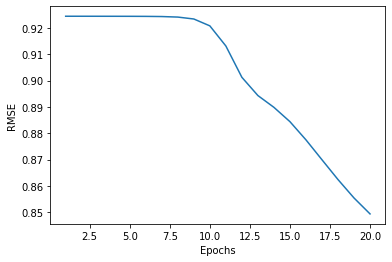

In [69]:
numpy.random.seed(4609)
model = SvdRecommend(0.05, 0.01, 10, 1048576, 20)
model.evaluate()

Task: Counting users and movies
Took 424.942266ms
Task: Packing data in COO format
Took 1261.786608ms
Task: Computing global mean
Took 240.524189ms
Task: Counting ratings per user
Took 26933.777959ms
Task: Counting ratings per movie
Took 25889.632854ms
Task: Computing user bias
Took 1717.51018ms
Task: Computing movie bias
Took 2589.502075ms
Task: Initializing parameters
Took 1139.229506ms
Task: Performing gradient descent


[============================================================] 1981442240/1981442240

Epoch 0: 0.9244260979942264
Epoch 1: 0.9244222690371573
Epoch 2: 0.9244176838939092
Epoch 3: 0.9244112176013041
Epoch 4: 0.9244002565984151
Epoch 5: 0.9243770829969676
Epoch 6: 0.9243152329226585
Epoch 7: 0.9241162525573434
Epoch 8: 0.9234054886217891
Epoch 9: 0.9208616824005764
Epoch 10: 0.9133681659227774
Epoch 11: 0.9015011828305467
Epoch 12: 0.8944792474673915
Epoch 13: 0.8900576327465718
Epoch 14: 0.8847404639485441
Epoch 15: 0.8779423522292793
Epoch 16: 0.8704460242830381
Epoch 17: 0.8629615703198097
Epoch 18: 0.8559496469018197
Epoch 19: 0.8498524163106955
Completed 1981442240/1981442240 in 5719301.57884ms
Took 5719304.150234ms
Evaluating 1408395 probe rows
Hyperparameters: (0.05, 0.05, 10, 1048576, 20)
Probe RMSE: 0.9571810589441522


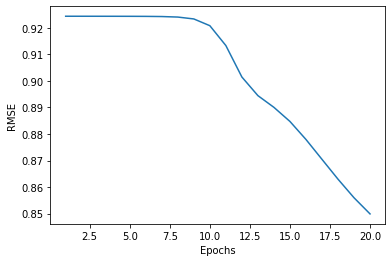

In [70]:
numpy.random.seed(4609)
model = SvdRecommend(0.05, 0.05, 10, 1048576, 20)
model.evaluate()

Task: Counting users and movies
Took 427.379726ms
Task: Packing data in COO format
Took 1265.095379ms
Task: Computing global mean
Took 232.467886ms
Task: Counting ratings per user
Took 21788.222637ms
Task: Counting ratings per movie
Took 21568.823259ms
Task: Computing user bias
Took 1678.577457ms
Task: Computing movie bias
Took 2553.723855ms
Task: Initializing parameters
Took 1036.572861ms
Task: Performing gradient descent


[=====================                                       ] 694553360/1981442240

Epoch 0: 0.9244261157924357
Epoch 1: 0.9243993954132889
Epoch 2: 0.9241161340956554
Epoch 3: 0.9176232615185957
Epoch 4: 0.9041405046622937
Epoch 5: 2.17593350392664
Epoch 6: 44.04031644047382
Completed 694553360/1981442240 in 2015566.864126ms
Took 2015567.125231ms
Evaluating 1408395 probe rows
Hyperparameters: (0.2, 0.01, 10, 1048576, 20)
Probe RMSE: 91.53377141266354


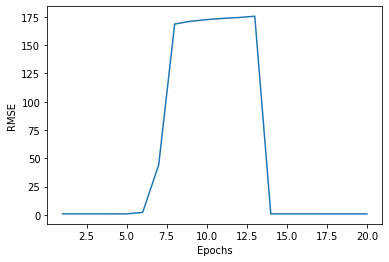

In [74]:
numpy.random.seed(4609)
model = SvdRecommend(0.2, 0.01, 10, 1048576, 20)
model.evaluate()

Task: Counting users and movies
Took 439.276115ms
Task: Packing data in COO format
Took 1244.485014ms
Task: Computing global mean
Took 234.36775ms
Task: Counting ratings per user
Took 28860.958795ms
Task: Counting ratings per movie
Took 28092.561753ms
Task: Computing user bias
Took 1698.441778ms
Task: Computing movie bias
Took 2563.542958ms
Task: Initializing parameters
Took 1364.168312ms
Task: Performing gradient descent


[============================================================] 1486081680/1486081680

Epoch 0: 0.9244261876607375
Epoch 1: 0.9244183884411168
Epoch 2: 0.924408427534641
Epoch 3: 0.924391979321987
Epoch 4: 0.9243549751193394
Epoch 5: 0.9242448299213566
Epoch 6: 0.9238559130821002
Epoch 7: 0.9224075799947182
Epoch 8: 0.9175079970061103
Epoch 9: 0.9066518617172681
Epoch 10: 0.8973571801599142
Epoch 11: 0.8934371539512002
Epoch 12: 0.8899770240024012
Epoch 13: 0.8851134544463649
Epoch 14: 0.8777147848469126
Completed 1486081680/1486081680 in 7349393.96206ms
Took 7349396.537532ms
Evaluating 1408395 probe rows
Hyperparameters: (0.05, 0.01, 20, 1048576, 15)
Probe RMSE: 0.969087852155832


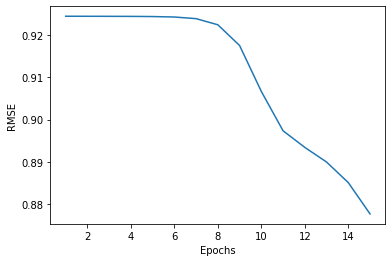

In [75]:
numpy.random.seed(4609)
model = SvdRecommend(0.05, 0.01, 20, 1048576, 15)
model.evaluate()